# Reconstruction of uniaxial permittivity tensor (uPT) in 3D
This reconstruction is based on the uPTI paper [here](https://www.biorxiv.org/content/10.1101/2020.12.15.422951v1): <br>
``` L.-H. Yeh, I. E. Ivanov, B. B. Chhun, S.-M. Guo, E. Hashemi, J. R. Byrum, J. A. Pérez-Bermejo, H. Wang, Y. Yu, P. G. Kazansky, B. R. Conklin, M. H. Han, and S. B. Mehta, "uPTI: uniaxial permittivity tensor imaging of intrinsic density and anisotropy," bioRxiv 2020.12.15.422951 (2020).```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fft2, ifft2, fftn, ifftn, fftshift, ifftshift

import pickle
import waveorder as wo
from scipy.ndimage import uniform_filter


import time


%matplotlib inline

## Initialization

### Load simulated images and parameters

In [2]:
# Load simulations

# 3D data
# file_name = 'uPTI_simulation_data_NA_det_147_NA_illu_140_3D_spoke_discrete_no_1528_ne_1553_no_noise_Born.npz'

# 2D data
file_name = 'uPTI_simulation_data_NA_det_147_NA_illu_140_2D_spoke_discrete_no_1528_ne_1553_no_noise_Born.npz'


array_loaded = np.load(file_name)
list_of_array_names = sorted(array_loaded)

for array_name in list_of_array_names:
    globals()[array_name] = array_loaded[array_name]

print(list_of_array_names)
I_meas = I_meas[1:]
I_meas.shape


['I_meas', 'NA_illu', 'NA_obj', 'Source_PolState', 'Source_cont', 'chi', 'lambda_illu', 'n_media', 'ps', 'psz', 'z_defocus']


(4, 9, 200, 200, 100)

### Setup reconstructor class

In [3]:
_, _, N, M, L = I_meas.shape
cali        = False               
bg_option   = 'global'            
use_gpu = True
gpu_id = 0


A_matrix = 0.5*np.array([[1, 1, 0], \
                         [1, 0, 1], \
                         [1, -1, 0], \
                         [1, 0, -1]])


setup = wo.waveorder_microscopy((N,M), lambda_illu, ps, NA_obj, NA_illu, z_defocus, chi, \
                                n_media=n_media, cali=cali, \
                                A_matrix=A_matrix, inc_recon='3D', \
                                illu_mode='Arbitrary', Source = Source_cont, Source_PolState=Source_PolState,\
                                pad_z=5, use_gpu=use_gpu, gpu_id=gpu_id)


### Illumination patterns used

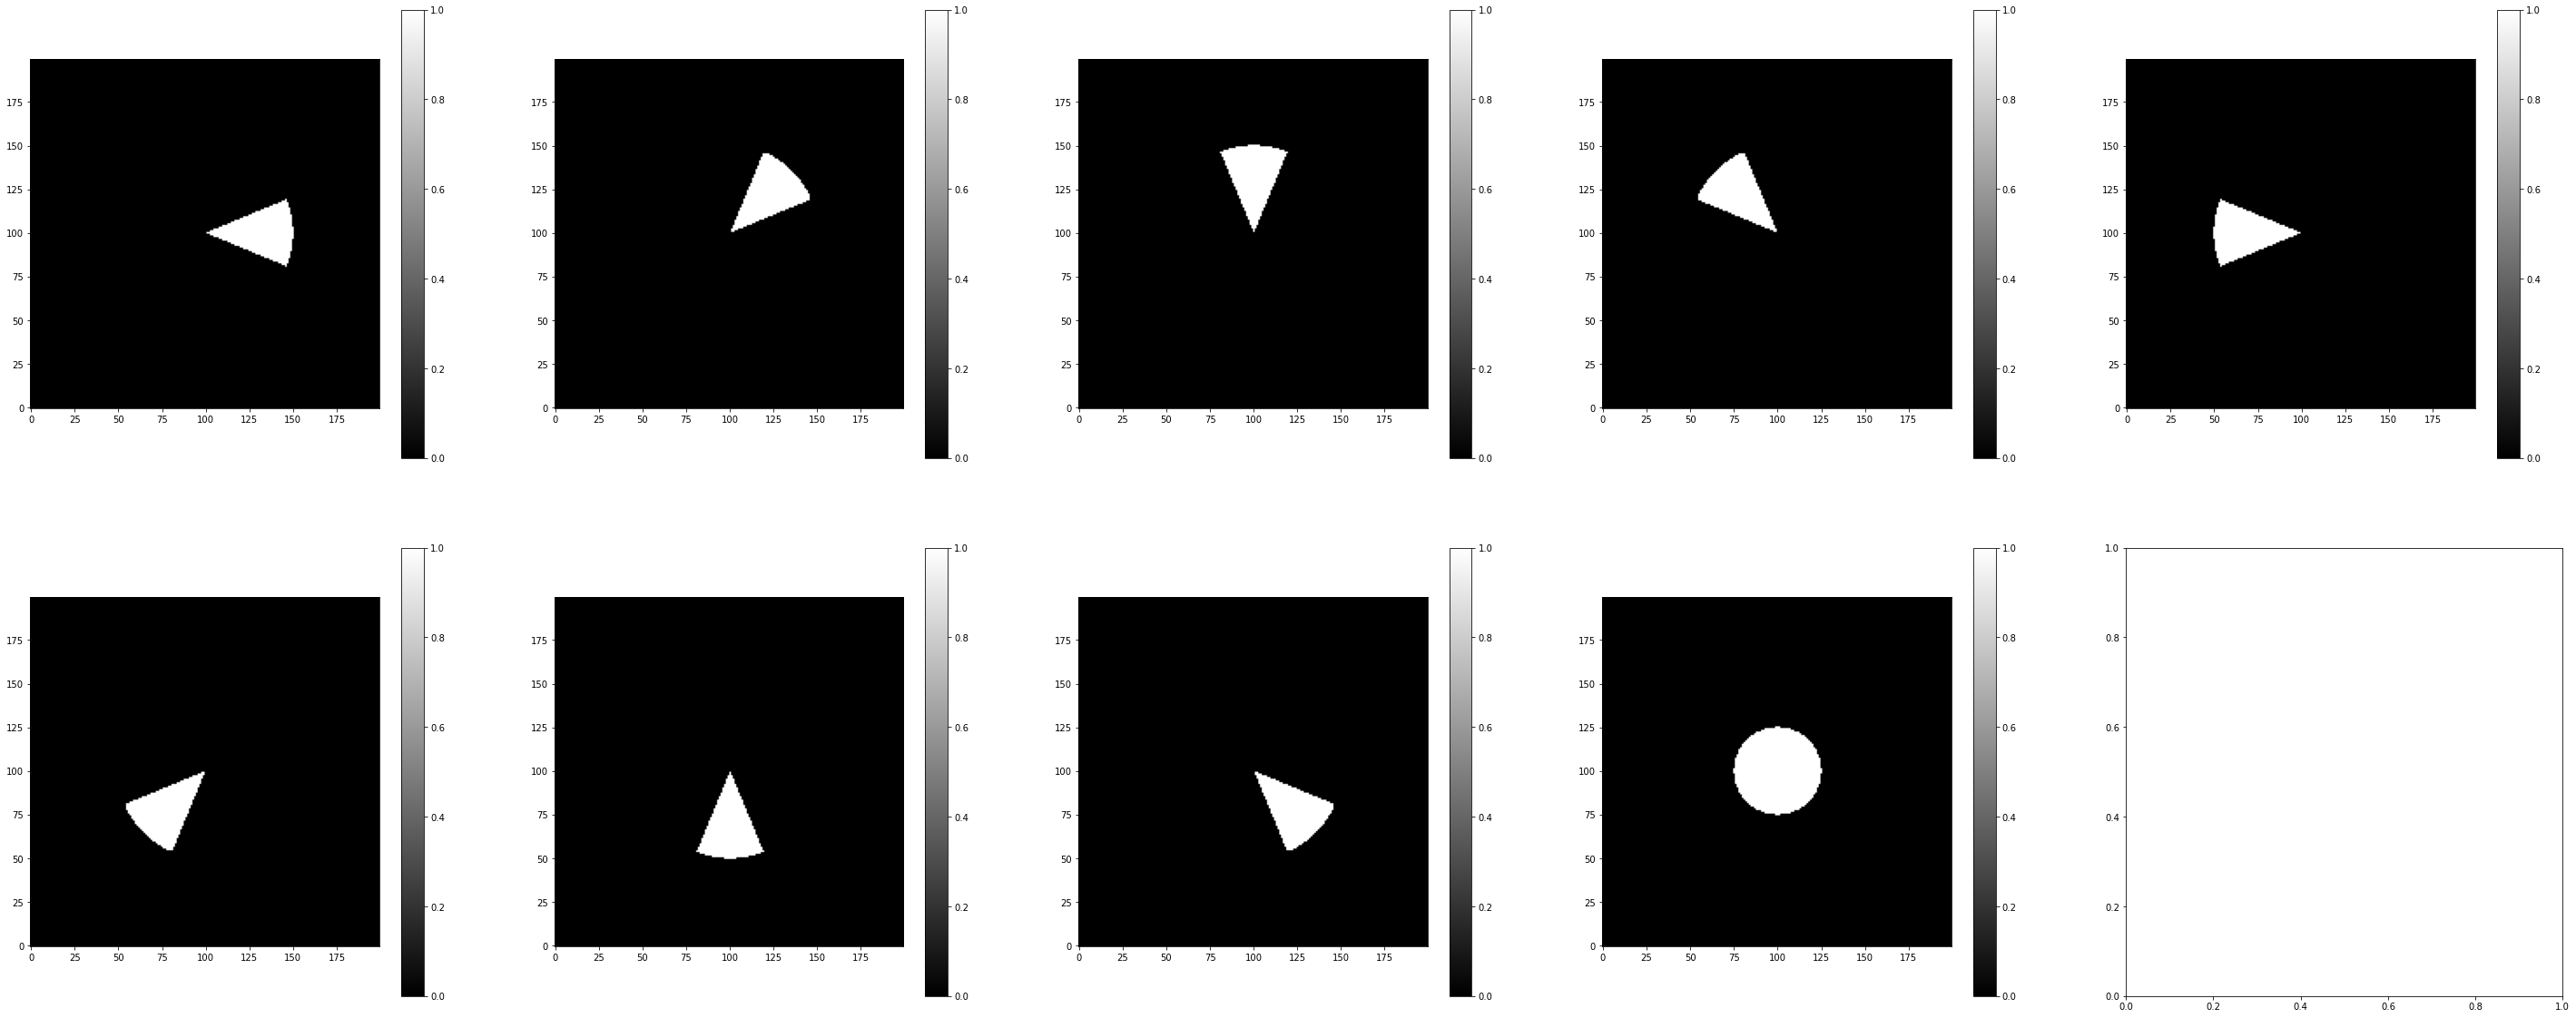

In [4]:
wo.plot_multicolumn(fftshift(Source_cont,axes=(1,2)), origin='lower', num_col=5)

### visualize XY and XZ sections of 3D transfer functions as a function of illumination patterns

In [5]:
# extract xy-slice and xz-slice of transfer functions for visualization
z_idx = (L+2*5)//2
plot_list = []
plot_list_xz = []
plot_list_abs = []
plot_list_xz_abs = []
for i in range(3):
    for j in range(7):
        OTF_fftshift = fftshift(setup.H_dyadic_OTF[i,j],axes=(1,2,3))
        
        plot_list.append(np.real(OTF_fftshift[:,:,:,z_idx]))
        plot_list.append(np.imag(OTF_fftshift[:,:,:,z_idx]))
        plot_list_xz.append(np.real(OTF_fftshift[:,N//2,:,:]))
        plot_list_xz.append(np.imag(OTF_fftshift[:,N//2,:,:]))
        plot_list_abs.append(np.abs(OTF_fftshift[:,:,:,z_idx]))
        plot_list_xz_abs.append(np.abs(OTF_fftshift[:,N//2,:,:]))

        
normalization_energy = np.max(np.sum(np.abs(np.transpose(np.real(np.stack(plot_list_abs)), (1,0,2,3))),axis=0),axis=(1,2))[1]


# generate strings for plotting
spt_list = [r'0r', r'0i', r'1c', r'1s', r'2c', r'2s', r'3']
stokes_list = [r'0', r'1', r'2']
reim_list = [r'Re', r'Im']

sum_transfer_function_titles = []
transfer_function_titles = []

for stokes_idx in stokes_list:
    for spt_idx in spt_list:
        sum_transfer_function_titles.append(r'$\sum_{\alpha} \tilde{H}_{'+stokes_idx+r', '+spt_idx+r', \alpha}$')

for stokes_idx in stokes_list:
    for spt_idx in spt_list:
        for reim_idx in reim_list:
            transfer_function_titles.append(r'$'+reim_idx+r'\{\tilde{H}_{'+stokes_idx+r', '+spt_idx+r', \alpha}\}$')
        

In [6]:
# xy section of the sum of transfer functions over all patterns
wo.parallel_4D_viewer(np.sum(np.abs(np.transpose(np.real(np.stack(plot_list_abs)), (1,0,2,3)))/normalization_energy,axis=0)[np.newaxis,...],\
                      num_col=7, size=8, colormap='jet', origin='lower', vrange=[0, 0.2], \
                      set_title=True, titles=sum_transfer_function_titles)

interactive(children=(IntSlider(value=0, description='stack_idx', max=0), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [7]:
# xz section of the sum of transfer functions over all patterns
wo.parallel_4D_viewer(np.sum(np.abs(np.transpose(np.real(np.stack(plot_list_xz_abs)), (1,0,3,2)))/normalization_energy,axis=0)[np.newaxis,...], \
                      num_col=7, size=8, colormap='jet', origin='lower', vrange=[0, 0.2],\
                      set_title=True, titles=sum_transfer_function_titles)

interactive(children=(IntSlider(value=0, description='stack_idx', max=0), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [25]:
# # animate xy section of transfer functions through different illumination patterns
# wo.parallel_4D_viewer(np.transpose(np.real(np.stack(plot_list))/normalization_energy, (1,0,2,3)), \
#                       num_col=14, size=5, colormap='jet', origin='lower', vrange=[-0.01, 0.01], \
#                       set_title=True, titles=transfer_function_titles)

interactive(children=(IntSlider(value=0, description='stack_idx', max=8), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

In [26]:
# # animate xz section of transfer functions through different illumination patterns
# wo.parallel_4D_viewer(np.transpose(np.real(np.stack(plot_list_xz))/normalization_energy, (1,0,3,2)), \
#                       num_col=14, size=5, colormap='jet', origin='lower', vrange=[-0.01, 0.01], \
#                       set_title=True, titles=transfer_function_titles)

interactive(children=(IntSlider(value=0, description='stack_idx', max=8), Output()), _dom_classes=('widget-int…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

## Reconstruct Stokes images and visualize them as a function of illumination pattern

In [8]:
S_image_recon = setup.Stokes_recon(I_meas)

S_image_tm = np.zeros_like(S_image_recon)

S_bg_mean_0 = np.mean(S_image_recon[0,:,:,:,:], axis=(1,2,3))[:,np.newaxis,np.newaxis,np.newaxis]
S_bg_mean_1 = np.mean(S_image_recon[1,:,:,:,:], axis=(1,2,3))[:,np.newaxis,np.newaxis,np.newaxis]
S_bg_mean_2 = np.mean(S_image_recon[2,:,:,:,:], axis=(1,2,3))[:,np.newaxis,np.newaxis,np.newaxis]


S_image_tm[0] = S_image_recon[0]/S_bg_mean_0-1
S_image_tm[1] = S_image_recon[1]/S_bg_mean_0 - S_bg_mean_1*S_image_recon[0]/S_bg_mean_0**2
S_image_tm[2] = S_image_recon[2]/S_bg_mean_0 - S_bg_mean_2*S_image_recon[0]/S_bg_mean_0**2

### visualize high-dimensional intensity and Stokes arrays (polarization, illumination, x, y, z)

In [9]:
# browse raw intensity stacks (stack_idx_1: z index, stack_idx2: pattern index)
wo.parallel_5D_viewer(np.transpose(I_meas,(4,1,0,2,3)), num_col=4, size=5, origin='lower', \
                      set_title=True, titles=[r'$I_{0}$',r'$I_{45}$',r'$I_{90}$', r'$I_{135}$'])

interactive(children=(IntSlider(value=0, description='stack_idx_1', max=99), IntSlider(value=0, description='s…

<function waveorder.visual.parallel_5D_viewer.<locals>.interact_plot(stack_idx_1, stack_idx_2)>

In [10]:
# browse uncorrected Stokes parameters (stack_idx_1: z index, stack_idx2: pattern index)
wo.parallel_5D_viewer(np.transpose(S_image_recon,(4,1,0,2,3)), num_col=3, size=5, origin='lower', \
                      set_title=True, titles=[r'$S_0$', r'$S_1$', r'$S_2$'])

interactive(children=(IntSlider(value=0, description='stack_idx_1', max=99), IntSlider(value=0, description='s…

<function waveorder.visual.parallel_5D_viewer.<locals>.interact_plot(stack_idx_1, stack_idx_2)>

In [11]:
# browse corrected Stokes parameters (stack_idx_1: z index, stack_idx2: pattern index)
wo.parallel_5D_viewer(np.transpose(S_image_tm,(4,1,0,2,3)), num_col=3, size=5, origin='lower', \
                     set_title=True, titles=[r'$S_0$', r'$S_1$', r'$S_2$'])

interactive(children=(IntSlider(value=0, description='stack_idx_1', max=99), IntSlider(value=0, description='s…

<function waveorder.visual.parallel_5D_viewer.<locals>.interact_plot(stack_idx_1, stack_idx_2)>

## 3D uPTI reconstruction

### 3D volumes of the components of scattering potential tensor

In [12]:
# Regularization parameters.

# reg_inc for 3D data
# reg_inc = np.array([1, 1, 5e1, 5e1, 2.5e1, 2.5e1, 5e1])*1
#####################


# reg_inc for 2D data
reg_inc = np.array([1, 1, 5e1, 5e1, 5e1, 5e1, 5e1])*1
#####################


reg_ret_pr = 1e-2


f_tensor = setup.scattering_potential_tensor_recon_3D_vec(S_image_tm, reg_inc=reg_inc, cupy_det=True)

Finished preprocess, elapsed time: 17.15
Finished reconstruction, elapsed time: 18.32


In [13]:
# browse the z-stack of components of scattering potential tensor
wo.parallel_4D_viewer(np.transpose(f_tensor,(3,0,1,2)), num_col=4, origin='lower', \
                      set_title=True, titles=[r'$f_{0r}$', r'$f_{0i}$', r'$f_{1c}$',r'$f_{1s}$',\
                                              r'$f_{2c}$', r'$f_{2s}$', r'$f_{3}$'])

interactive(children=(IntSlider(value=0, description='stack_idx', max=99), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

### 3D volumes of principal retardance, 3D orientation, and optic sign 

|  20  |  3.23e+08  |   46.20   |
Finish optic sign estimation, elapsed time: 46.41


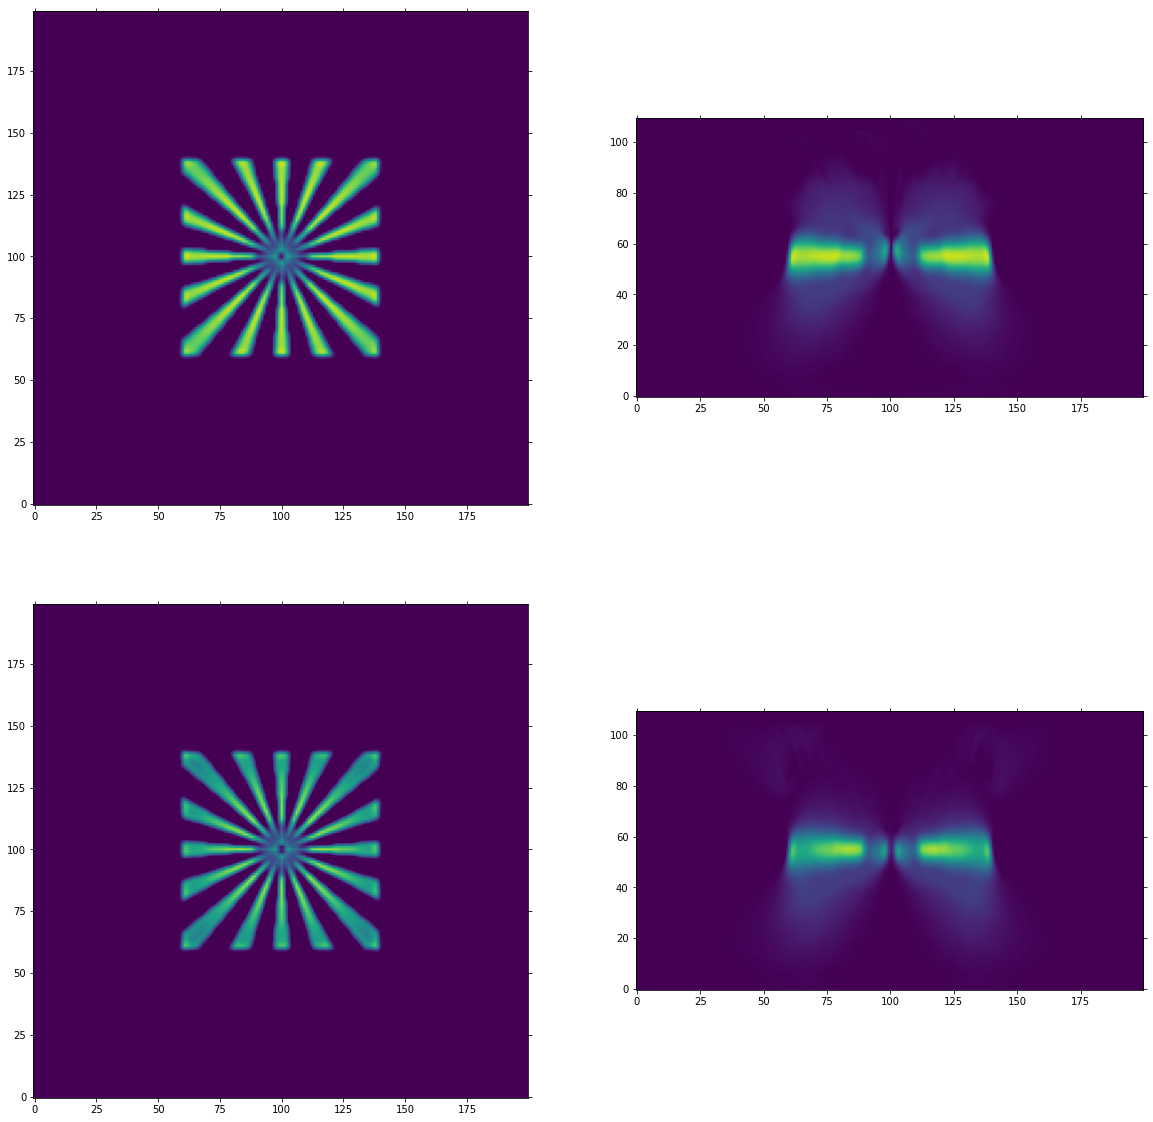

In [14]:
# reconstruct 3D anisotropy (principal retardance, 3D orientation, optic sign probability)
# material type: 
# "positive" -> only solution of positively uniaxial material
# "negative" -> only solution of negatively uniaxial meterial
# "unknown" -> both solutions of positively and negatively uniaxial material + optic sign estimation

retardance_pr, azimuth, theta, mat_map = setup.scattering_potential_tensor_to_3D_orientation(f_tensor, S_image_tm,\
                                                                                             material_type='unknown', reg_ret_pr = reg_ret_pr, itr=20, step_size=0.1, fast_gpu_mode=True)

In [15]:
# scaling to the physical properties of the material

# optic sign probability
p_mat_map = wo.optic_sign_probability(mat_map,mat_map_thres=0.2)



# absorption and phase
phase = wo.phase_inc_correction(f_tensor[0], retardance_pr[0], theta[0])
absorption = f_tensor[1].copy()
phase_PT, absorption_PT, retardance_pr_PT = [wo.unit_conversion_from_scattering_potential_to_permittivity(SP_array, lambda_illu, n_media=n_media, imaging_mode = '3D') 
                                             for SP_array in [phase, absorption, retardance_pr]]



In [16]:
# clean up GPU memory leftorver

import gc
import cupy as cp

gc.collect()
cp.get_default_memory_pool().free_all_blocks()

## Visualize reconstructed physical properties of simulated sample

### Reconstructed phase, absorption, principal retardance, azimuth, and inclination assuming (+) and (-) optic sign

In [20]:
# browse the reconstructed physical properties
wo.parallel_4D_viewer(np.transpose(np.stack([phase_PT, retardance_pr_PT[0], azimuth[0], theta[0], \
                                             absorption_PT, retardance_pr_PT[1], azimuth[1], theta[1]]),(3,0,1,2)), num_col=4, origin='lower', \
                      set_title=True, titles=[r'phase',r'principal retardance (+)', r'$\omega$ (+)', r'$\theta$ (+)',\
                                              r'absorption',r'principal retardance (-)', r'$\omega$ (-)', r'$\theta$ (-)'])

interactive(children=(IntSlider(value=0, description='stack_idx', max=99), Output()), _dom_classes=('widget-in…

<function waveorder.visual.parallel_4D_viewer.<locals>.interact_plot(stack_idx)>

### Phase, principal retardance, color-coded 3D orientation (azimuth and inclination), and optic signtruction

Text(0.5, 1.0, 'inclination (+) (xz)')

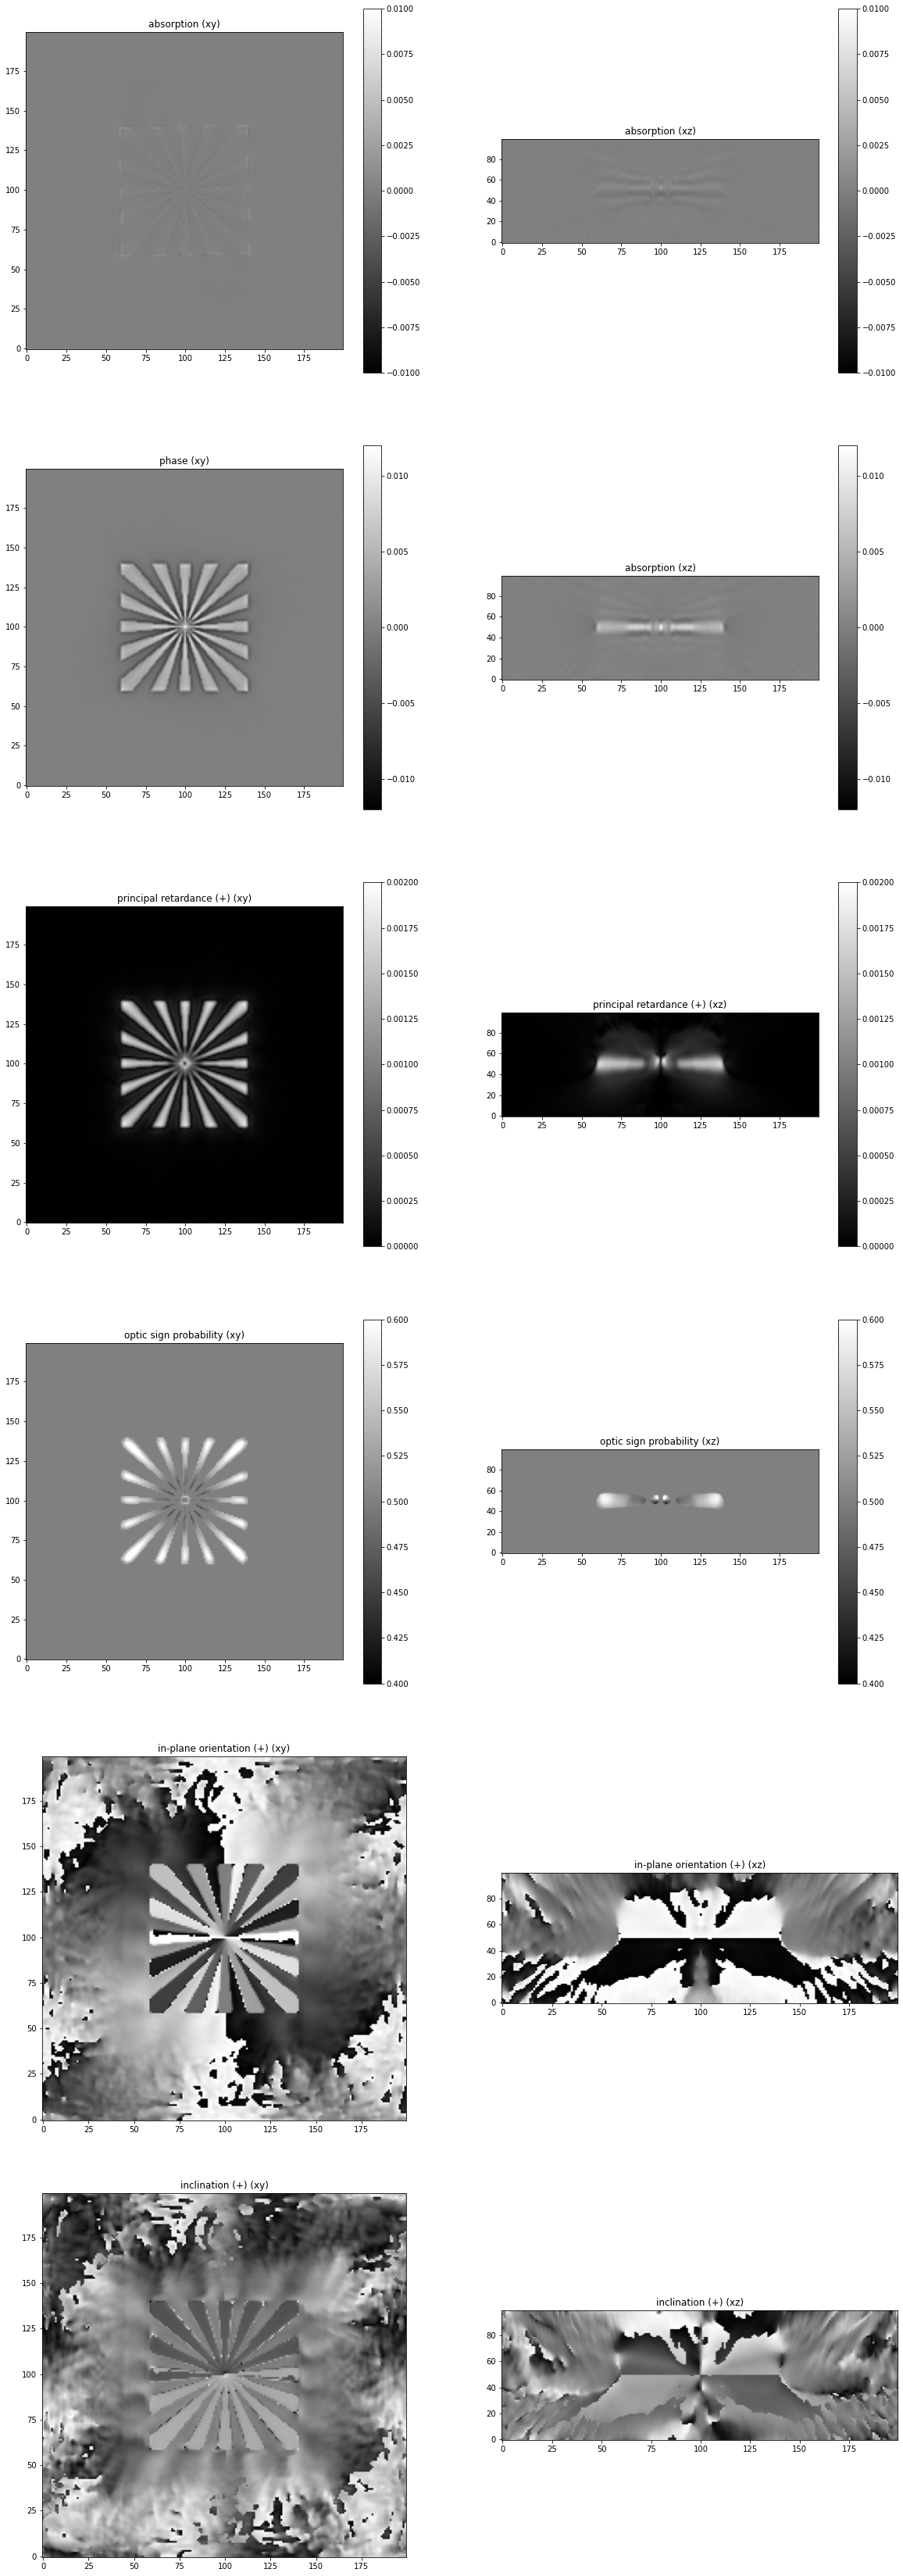

In [29]:
## display parameters for 3D dataset ##
# z_layer = 25
# y_layer = 100
# x_layer = 100
# phase_min = -0.02
# phase_max = 0.02
# ret_min = 0
# ret_max = 0.007
# p_min = 0.4
# p_max = 0.6
# abs_min = -0.02
# abs_max = 0.02
######################################

## display parameters for 2D dataset ##
z_layer = 50
y_layer = 100
x_layer = 100
phase_min = -0.012
phase_max = 0.012
ret_min = 0
ret_max = 0.002
p_min = 0.4
p_max = 0.6
abs_min = -0.01
abs_max = 0.01
######################################


fig,ax = plt.subplots(6,2,figsize=(20,60))
sub_ax = ax[0,0].imshow(absorption_PT[:,:,z_layer], cmap='gray', origin='lower', vmin=abs_min, vmax=abs_max)
ax[0,0].set_title('absorption (xy)')
plt.colorbar(sub_ax, ax=ax[0,0])

sub_ax = ax[0,1].imshow(np.transpose(absorption_PT[y_layer,:,:]), cmap='gray', origin='lower',vmin=abs_min, vmax=abs_max,aspect=psz/ps)
ax[0,1].set_title('absorption (xz)')
plt.colorbar(sub_ax, ax=ax[0,1])

sub_ax = ax[1,0].imshow(phase_PT[:,:,z_layer], cmap='gray', origin='lower', vmin=phase_min, vmax=phase_max)
ax[1,0].set_title('phase (xy)')
plt.colorbar(sub_ax, ax=ax[1,0])

sub_ax = ax[1,1].imshow(np.transpose(phase_PT[y_layer,:,:]), cmap='gray', origin='lower',vmin=phase_min, vmax=phase_max,aspect=psz/ps)
ax[1,1].set_title('absorption (xz)')
plt.colorbar(sub_ax, ax=ax[1,1])

sub_ax = ax[2,0].imshow(np.abs(retardance_pr_PT[0,:,:,z_layer]), cmap='gray', origin='lower',vmin=ret_min, vmax=ret_max)
ax[2,0].set_title('principal retardance (+) (xy)')
plt.colorbar(sub_ax, ax=ax[2,0])

sub_ax = ax[2,1].imshow(np.transpose(np.abs(retardance_pr_PT[0,y_layer,:,:])), cmap='gray', origin='lower',vmin=ret_min, vmax=ret_max,aspect=psz/ps)
ax[2,1].set_title('principal retardance (+) (xz)')
plt.colorbar(sub_ax, ax=ax[2,1])

sub_ax = ax[3,0].imshow(np.abs(p_mat_map[:,:,z_layer]), cmap='gray', origin='lower',vmin=p_min, vmax=p_max)
ax[3,0].set_title('optic sign probability (xy)')
plt.colorbar(sub_ax, ax=ax[3,0])

sub_ax = ax[3,1].imshow(np.transpose(np.abs(p_mat_map[y_layer,:,:])), cmap='gray', origin='lower',vmin=p_min, vmax=p_max, aspect=psz/ps)
ax[3,1].set_title('optic sign probability (xz)')
plt.colorbar(sub_ax, ax=ax[3,1])

sub_ax = ax[4,0].imshow(azimuth[0,:,:,z_layer], cmap='gray', origin='lower',vmin=0, vmax=np.pi)
ax[4,0].set_title('in-plane orientation (+) (xy)')

sub_ax = ax[4,1].imshow(np.transpose(azimuth[0,y_layer,:,:]), cmap='gray', origin='lower', vmin=0, vmax=np.pi, aspect=psz/ps)
ax[4,1].set_title('in-plane orientation (+) (xz)')

sub_ax = ax[5,0].imshow(theta[0,:,:,z_layer], cmap='gray', origin='lower',vmin=0, vmax=np.pi)
ax[5,0].set_title('inclination (+) (xy)')

sub_ax = ax[5,1].imshow(np.transpose(theta[0,y_layer,:,:]), cmap='gray', origin='lower', vmin=0, vmax=np.pi, aspect=psz/ps)
ax[5,1].set_title('inclination (+) (xz)')



### Render 3D orientation with 3D colorsphere (azimuth and inclination)

In [30]:
# create color-coded orientation images

## display parameters for 3D dataset ##
# ret_min_color = 0
# ret_max_color = 0.007
######################################


## display parameters for 2D dataset ##
ret_min_color = 0
ret_max_color = 0.002
######################################

orientation_3D_image = np.transpose(np.array([azimuth[0]/2/np.pi, theta[0], (np.clip(np.abs(retardance_pr_PT[0]),ret_min_color,ret_max_color)-ret_min_color)/(ret_max_color-ret_min_color)]),(3,1,2,0))
orientation_3D_image_RGB = wo.orientation_3D_to_rgb(orientation_3D_image, interp_belt = 20/180*np.pi, sat_factor = 1)


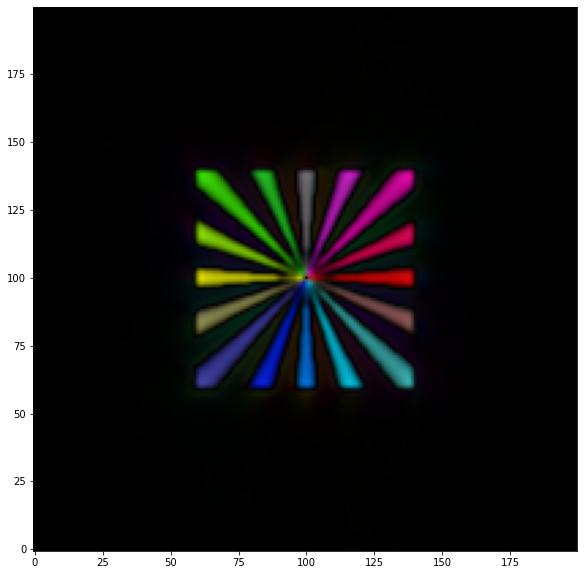

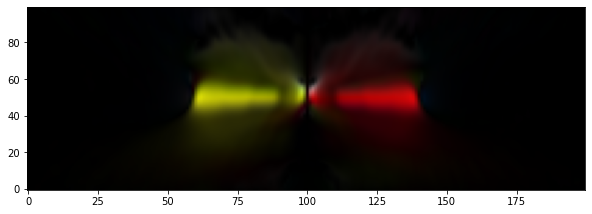

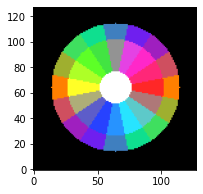

In [32]:

plt.figure(figsize=(10,10))
plt.imshow(orientation_3D_image_RGB[z_layer], origin='lower')
plt.figure(figsize=(10,10))
plt.imshow(orientation_3D_image_RGB[:,y_layer], origin='lower',aspect=psz/ps)
# plot the top view of 3D orientation colorsphere
plt.figure(figsize=(3,3))
wo.orientation_3D_colorwheel(wheelsize=128, circ_size=50, interp_belt=20/180*np.pi, sat_factor=1, discretize=True)


### Render 3D orientation with 2 channels (in-plane orientation and out-of-plane tilt)

In [35]:
# in-plane orientation
from matplotlib.colors import hsv_to_rgb

I_hsv = np.transpose(np.array([(azimuth[0])%np.pi/np.pi, \
                               np.ones_like(retardance_pr_PT[0]), \
                               (np.clip(np.abs(retardance_pr_PT[0]),ret_min_color,ret_max_color)-ret_min_color)/(ret_max_color-ret_min_color)]), (3,1,2,0))
in_plane_orientation = hsv_to_rgb(I_hsv.copy())

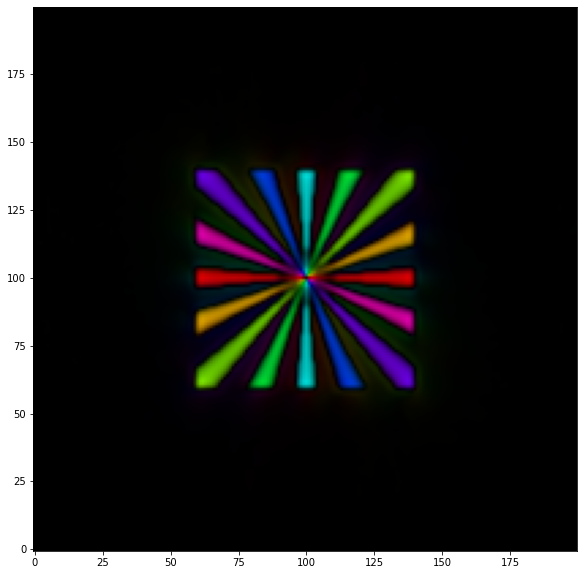

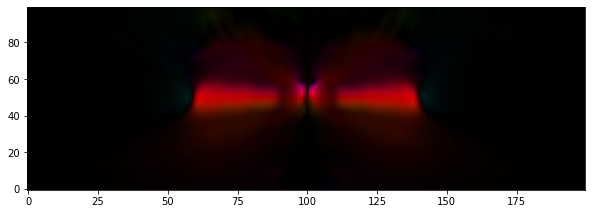

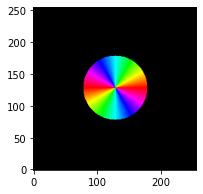

In [41]:
plt.figure(figsize=(10,10))
plt.imshow(in_plane_orientation[z_layer], origin='lower')
plt.figure(figsize=(10,10))
plt.imshow(in_plane_orientation[:,y_layer], origin='lower',aspect=psz/ps)
plt.figure(figsize=(3,3))
wo.orientation_2D_colorwheel()

In [38]:
# out-of-plane tilt

threshold_inc = np.pi/90

I_hsv = np.transpose(np.array([(-np.maximum(0,np.abs(theta[0]-np.pi/2)-threshold_inc)+np.pi/2+threshold_inc)/np.pi, \
                               np.ones_like(retardance_pr_PT[0]), \
                               (np.clip(np.abs(retardance_pr_PT[0]),ret_min_color,ret_max_color)-ret_min_color)/(ret_max_color-ret_min_color)]), (3,1,2,0))
out_of_plane_tilt = hsv_to_rgb(I_hsv.copy())

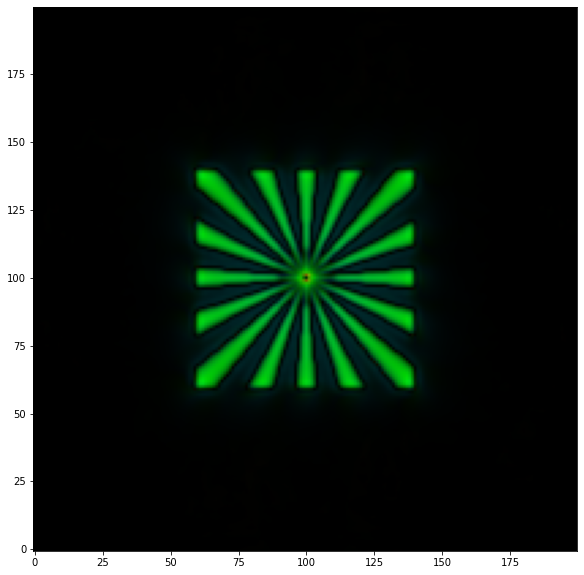

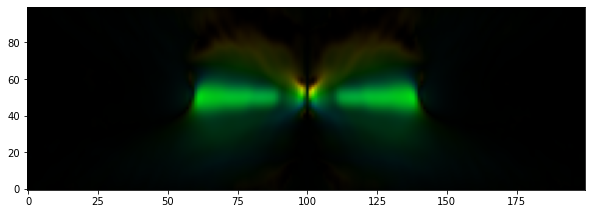

In [39]:
plt.figure(figsize=(10,10))
plt.imshow(out_of_plane_tilt[z_layer], origin='lower')
plt.figure(figsize=(10,10))
plt.imshow(out_of_plane_tilt[:,y_layer], origin='lower',aspect=psz/ps)

## Evaluation of reconstructed 3D orientation

### 3D orientation overlaid as lines on retardance image.

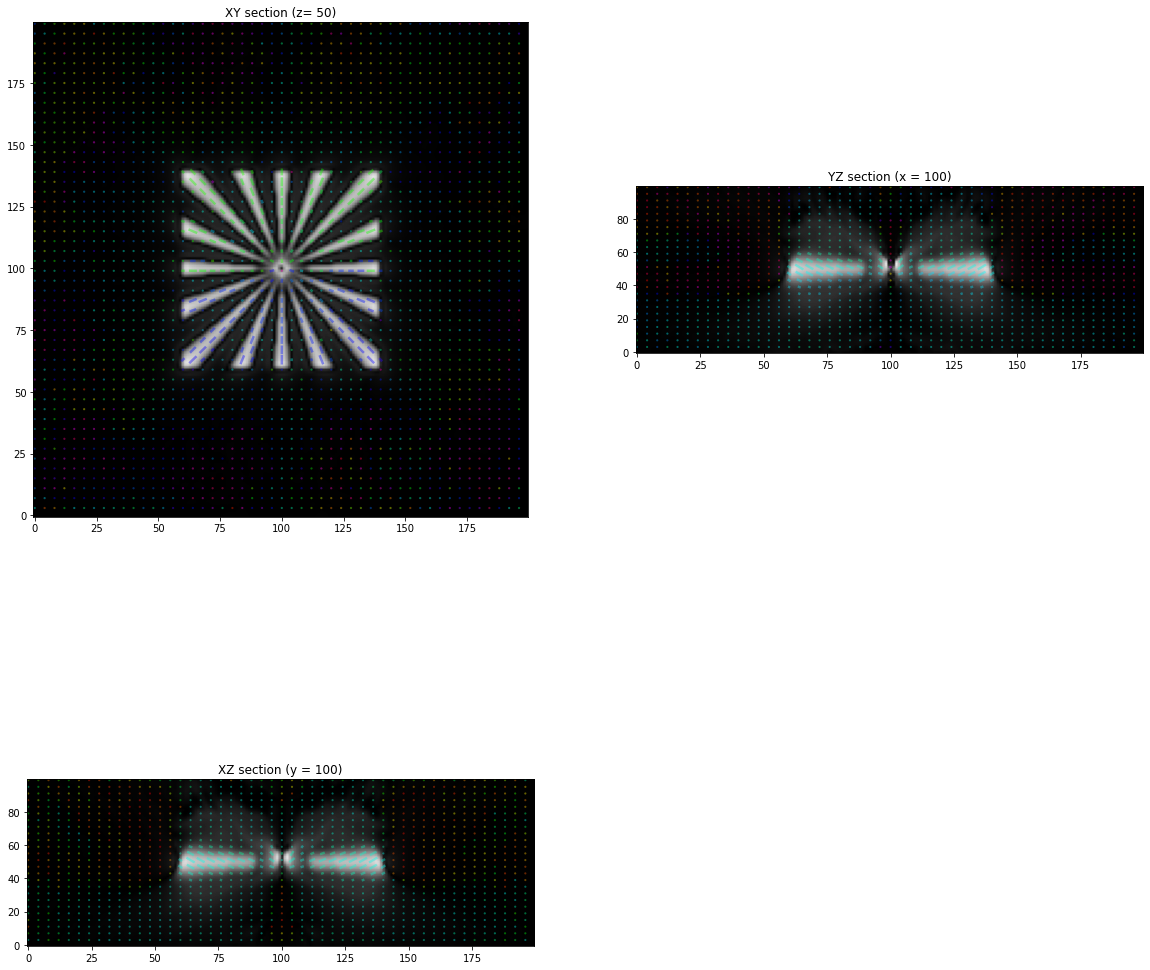

In [45]:
vect = np.zeros((3,)+azimuth.shape)
vect[0] = np.sin(theta)*np.cos(azimuth)
vect[1] = np.sin(theta)*np.sin(azimuth)
vect[2] = np.cos(theta)

theta_x = np.arccos(vect[0])
azimuth_x = np.arctan2(vect[2], vect[1])

theta_y = np.arccos(vect[1])
azimuth_y = np.arctan2(vect[2], vect[0])

z_step = psz

### 3D data parameter ###
# spacing = 4
# z_layer =  25
# x_layer = 100
# y_layer = 100 
# linelength_scale = 10
#########################


### select slices to plot ###
spacing = 4
z_layer =  50
x_layer = 100
y_layer = 100
linelength_scale = 20
#########################


fig,ax = plt.subplots(2,2,figsize=(20,20))
wo.plot3DVectorField(np.abs(retardance_pr_PT[0,:,:,z_layer]), azimuth[0,:,:,z_layer], theta[0,:,:,z_layer], 
                     anisotropy=0.4*np.abs(retardance_pr_PT[0,:,:,z_layer]), cmapImage='gray', clim=[ret_min, ret_max], aspect=1, 
                     spacing=spacing, window=spacing, linelength=spacing*linelength_scale, linewidth=1, cmapAzimuth='hsv', alpha=0.4, subplot_ax=ax[0,0])
ax[0,0].set_title(f'XY section (z= {z_layer})')

wo.plot3DVectorField(np.transpose(np.abs(retardance_pr_PT[0,:,x_layer,:])), np.transpose(azimuth_x[0,:,x_layer,:]), np.transpose(theta_x[0,:,x_layer,:]), 
                     anisotropy=0.4*np.transpose(np.abs(retardance_pr_PT[0,:,x_layer,:])), cmapImage='gray', clim=[ret_min, ret_max], aspect=z_step/ps, 
                     spacing=spacing, window=spacing, linelength=spacing*linelength_scale, linewidth=1, cmapAzimuth='hsv', alpha=0.4, subplot_ax=ax[0,1])
ax[0,1].set_title(f'YZ section (x = {x_layer})')

wo.plot3DVectorField(np.transpose(np.abs(retardance_pr_PT[0,y_layer,:,:])), np.transpose(azimuth_y[0,y_layer,:,:]), np.transpose(theta_y[0,y_layer,:,:]),
                     anisotropy=0.4*np.transpose(np.abs(retardance_pr_PT[0,y_layer,:,:])), cmapImage='gray', clim=[ret_min, ret_max], aspect=z_step/ps, 
                     spacing=spacing, window=spacing, linelength=spacing*linelength_scale, linewidth=1, cmapAzimuth='hsv', alpha=0.4, subplot_ax=ax[1,0])
ax[1,0].set_title(f'XZ section (y = {y_layer})')

ax[1,1].remove()

### Angular histogram of computed 3D orientation

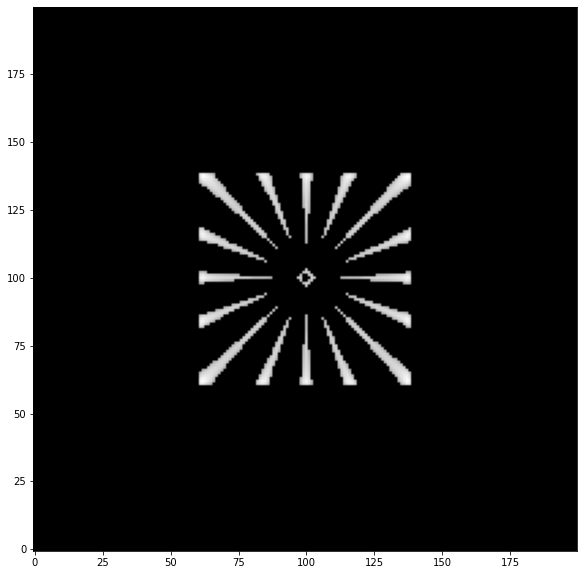

In [46]:
ret_mask = np.abs(retardance_pr_PT[0]).copy()

## threshold parameters for 3D dataset ##
# ret_mask[ret_mask<0.15]=0
######################################


## threshold parameters for 2D dataset ##
ret_mask[ret_mask<0.00125]=0
######################################

plt.figure(figsize=(10,10))
plt.imshow(ret_mask[:,:,z_layer], cmap='gray', origin='lower')

(<Figure size 720x720 with 2 Axes>, <PolarAxesSubplot:>)

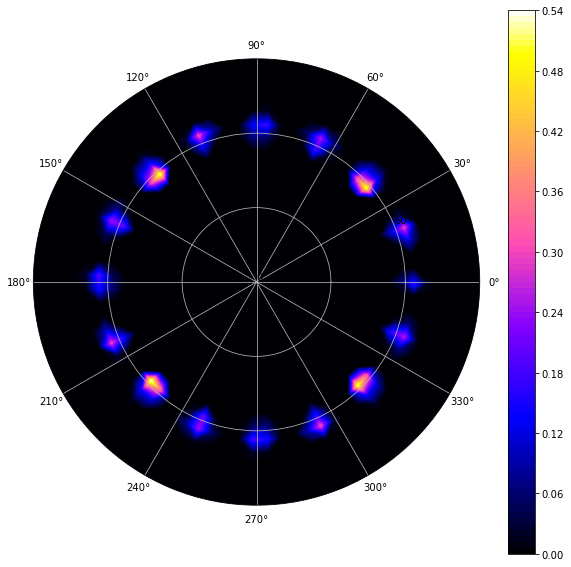

In [47]:
wo.orientation_3D_hist(azimuth[0].flatten(), \
                       theta[0].flatten(), \
                       ret_mask.flatten(),\
                       bins=36, num_col=1, size=10, contour_level = 100, hist_cmap='gnuplot2', top_hemi=True)

In [48]:
import cupy as cp
import gc
gc.collect()
cp.get_default_memory_pool().free_all_blocks()